In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


from numpy.polynomial import polynomial as P


##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [2046]:
region = 'timbuktu'
sahel = [-10,15,9,19]
x=2
y=1
f = 1
ouaga=[-1.52-x,-1.52+x,12.38-y,12.38+y]  #12.3714° N, 1.5197° W
niamey = [2.13-x,2.13+x+1, 13.51-y,13.51+y] #13.5116° N, 2.1254° E
timbuktu = [ -3-x,-3+x, 16.77-y,16.77+y] #16.7666° N, 3.0026° W

#     ouaga=[-2.52,0.52,11.38,13.38]
#     niamey = [1.13,3.13, 12.51,14.51] #13.5116° N, 2.1254° E
#     timbuktu = [ -2.9,-0.9, 15.77,17.77] #16.7666° N, 3.0026° W

regions = {'sahel':sahel, 'ouaga':ouaga, 'niamey':niamey, 'timbuktu':timbuktu}
domain = regions[region]

vlist = ['prcp']
ttag='hourly'
xstep = 20

def calc_mcs_stuff(dic, domain):
    m1=5
    m2=10

    dicout = dic[(dic.lon>=domain[0])&(dic.lon<=domain[1])&(dic.lat>=domain[2])&(dic.lat<=domain[3])& (dic.month>=m1) & (dic.month<=m2) & (dic.q925>=8.) & (dic.shear>0) &  (dic.prcp>=0.1) & (dic.theta_e>=-40) & (dic.area>=5000) & (dic.tmin<=-55)]
    return dicout

Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [2047]:
def calc_mcs(dd):

    obs_mcs_d = pkl.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/obs_MCS_fig2.p', "rb"))
    cp4hist_mcs_d = pkl.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4hist_MCS_fig2_5-20N.p', "rb"))
    cp4fut_mcs_d = pkl.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4fut_MCS_fig2_5-20N.p', "rb"))

    obs_mcs = calc_mcs_stuff(obs_mcs_d, dd)
    cp4hist_mcs = calc_mcs_stuff(cp4hist_mcs_d, dd)
    cp4fut_mcs = calc_mcs_stuff(cp4fut_mcs_d, dd)
    
    return cp4hist_mcs, cp4fut_mcs, obs_mcs

In [2048]:
cp4, cp4f, obs = calc_mcs(domain)

In [2049]:
# p95_tcw_hist = np.percentile(cp4.tcwv, 95)
# p95_tcw_fut = np.percentile(cp4f.tcwv, 95)

In [2050]:
# cp4.prcp[cp4.tcwv>=p95_tcw_hist]

In [2051]:
# p=95
# p95_precip_hist = cp4.prcp[cp4.tcwv>=p95_tcw_hist]
# p95_precip_fut = cp4f.prcp[cp4f.tcwv>=p95_tcw_fut]

# prcp_rel = ((np.percentile(p95_precip_fut,p)-np.percentile(p95_precip_hist,p))/ np.percentile(p95_precip_hist,p)) / ((np.percentile(p95_tcw_fut,p)-np.percentile(p95_tcw_hist,p))/ np.percentile(p95_tcw_hist,p))

In [2052]:
# prcp_rel

Text(0.5, 1.0, '-0.55')

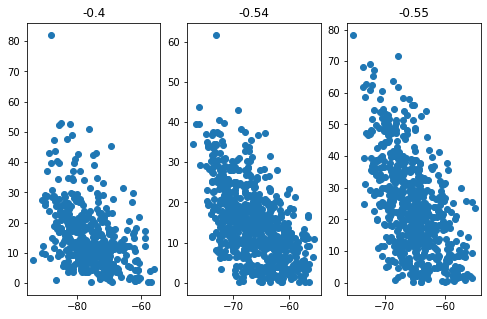

In [2053]:

cp4s = [obs.tmin, obs.prcp] # gpm
cp25s = [cp4.tmin,cp4.prcp] #cp4
futur = [cp4f.tmin, cp4f.prcp] 


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))





In [2054]:
if ttag == 'hourly':
    ptag = [0.1]+list(np.arange(xstep,76,xstep))+[75,85,95,99.9]
else:
    ptag =  [0.1]+list(np.arange(xstep,76,xstep))+[75,85,95,99.9]
print(ptag)
def get_percentile(x, ttag):

#     if ttag == 'hourly':
#         ptag = [0.01]+list(np.arange(10,91,10))+[99.99]
#     else:
#         ptag =  [0.01]+list(np.arange(10,91,10))+[99.99]
                         
    return np.percentile(x[np.isfinite(x)], ptag) 

[0.1, 20, 40, 60, 75, 85, 95, 99.9]


In [2055]:
percent=95
valmin = 3
obs_q925 = hist2d.create_2dhist_centile(obs.shear, obs.q925, get_percentile(obs.shear, ttag), get_percentile(obs.q925, ttag), obs, vlist, percentile=percent, valmin=valmin)
obs_theta = hist2d.create_2dhist_centile(obs.shear, obs.theta_e, get_percentile(obs.shear, ttag), get_percentile(obs.theta_e, ttag), obs, vlist, percentile=percent, valmin=valmin)
obs_tcwv = hist2d.create_2dhist_centile(obs.shear, obs.tcwv, get_percentile(obs.shear, ttag), get_percentile(obs.tcwv, ttag), obs, vlist, percentile=percent, valmin=valmin)

cp4_q925 = hist2d.create_2dhist_centile(cp4.shear, cp4.q925, get_percentile(cp4.shear, ttag), get_percentile(cp4.q925, ttag), cp4, vlist, percentile=percent, valmin=valmin)
cp4_theta = hist2d.create_2dhist_centile(cp4.shear, cp4.theta_e,get_percentile(cp4.shear, ttag), get_percentile(cp4.theta_e, ttag), cp4, vlist, percentile=percent, valmin=valmin)
cp4_tcwv = hist2d.create_2dhist_centile(cp4.shear, cp4.tcwv, get_percentile(cp4.shear, ttag), get_percentile(cp4.tcwv, ttag), cp4, vlist, percentile=percent, valmin=valmin)

cp4f_q925 = hist2d.create_2dhist_centile(cp4f.shear, cp4f.q925, get_percentile(cp4f.shear, ttag), get_percentile(cp4f.q925, ttag), cp4f, vlist, percentile=percent, valmin=valmin)
cp4f_theta = hist2d.create_2dhist_centile(cp4f.shear, cp4f.theta_e, get_percentile(cp4f.shear, ttag), get_percentile(cp4f.theta_e, ttag), cp4f, vlist, percentile=percent, valmin=valmin)
cp4f_tcwv = hist2d.create_2dhist_centile(cp4f.shear, cp4f.tcwv, get_percentile(cp4f.shear, ttag), get_percentile(cp4f.tcwv, ttag), cp4f, vlist, percentile=percent, valmin=valmin)

In [2056]:
#xstep = len([0.1]+list(np.arange(10,91,10))+[99.9])-1

In [2057]:
#[0.1]+list(np.arange(10,91,10))+[99.9]

In [2058]:
def plot_dic_prcp(dic, vmin, vmax, xlabel, ylabel, tag):
    odic = {
    'data' : dic['prcp'],
    'ybins' : dic['ybins'],
    'xbins' : dic['xbins'],
    'title' : tag+': maximum precipitation',
    'valid' : dic['prcp_val'],
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : vmin, 
    'vmax' : vmax, 
    'ylabel' : ylabel,
    'xlabel' : xlabel     
    }
    return odic
    

In [2059]:
def binning_hist(bins, shape):
    scat = np.repeat(bins,shape[1],axis=0).reshape(shape)
    return scat

In [2060]:
shape = obs_q925['prcp'].shape
shapet = obs_tcwv['prcp'].shape

In [2061]:
shape

(8, 8)

In [2062]:
def binning_2dhist(prcp, bins):
    ps = []
    qps = []
    sbox = []
    tbox = []
    mean = []
    percup = []
    percdown = []
    tmean = []
    tpercup = []
    tpercdown = []
    pvals = []
    for sh in np.unique(bins):
        
            vvflag = True
            ttflag = True
        
            vals = prcp[(sh==bins)]
            vals[vals==0] = np.nan

            ps.append(np.nanmax(vals)-np.nanmin(vals))
            try:
                qps.append(np.percentile(vals[np.isfinite(vals)],75)-np.percentile(vals[np.isfinite(vals)],25))
            except:
                qps.append(np.nan)
            sbox.append(vals)
            #ipdb.set_trace()
            
            vv = np.nanmean(vals)
            nans = np.sum(np.isnan(vals))
            if np.sum(np.isfinite(vals))<3:
                #ipdb.set_trace()
                vv = np.nan
                vvflag = False
            pvals.append(np.sum(np.isfinite(vals)))
            
            mean.append(vv)
            if vvflag:
                try:
                    percup.append(np.percentile(vals[np.isfinite(vals)],90)) # 75, 25
                    percdown.append(np.percentile(vals[np.isfinite(vals)],10))
                except:
                    percup.append(np.nan)
                    percdown.append(np.nan)
            else:
                percup.append(np.nan)
                percdown.append(np.nan)
                
                   
    print(np.median(np.array(qps)[np.isfinite(np.array(qps))]))
    return ps, qps, sbox, mean, percup, percdown, pvals

In [2063]:
def run_binning(dic, scat):
    
    binns = np.array(ptag) #np.arange(0,101,xstep) # collbins
    binns = np.round(binns[0:-1]+((binns[1::]-binns[0:-1])/2),2)
    #ipdb.set_trace()
    def linregress(bins,data, pval):
        data = np.array(data)
        pos = np.isfinite(data)
        inbins = bins[pos]
        indata = data[pos]
        return stats.linregress(inbins, indata)

    deltaPS, deltaQPS, sboxplot, pmean,p90,p10, pval = binning_2dhist(dic['prcp'], scat)
    
    collbins = np.round(np.unique(scat),2)
    collbins = np.round(collbins[0:-1]+((collbins[1::]-collbins[0:-1])/2),2)
#     #ipdb.set_trace()
#     slope, intercept, r_value, p_value, std_err = linregress(binns, pmean[0:-1], pval[0:-1])
#     rslope, rintercept, rr_value, rp_value, rstd_err = linregress(collbins, pmean[0:-1], pval[0:-1])
    
    odic = {
#         'slope' : slope,
#         'intercept' : intercept,
#         'rval' : r_value,
#         'pval' : p_value,
#         'std_err' : std_err,
        'prcp_span' : deltaPS,
        'prcp_IQR' : deltaQPS,
        'pbox' : sboxplot,
        'pmean' : pmean[0:-1],
        'p90' : p90[0:-1],
        'p10' : p10[0:-1],
        'bins' : binns,
        'rbins' : collbins,
#         'rslope' : rslope,
#         'rintercept' : rintercept,
#         'rrval' : rr_value,
#         'rpval' : rp_value,
#         'rstd_err' : rstd_err
    }
    
    return odic

In [2064]:
# obs_tcwv_shear = run_binning(obs_tcwv,binning_hist(get_percentile(obs.shear, ttag)[np.newaxis,:],shape))
# cp4_tcwv_shear = run_binning(cp4_tcwv,binning_hist(get_percentile(cp4.shear, ttag)[np.newaxis,:],shape))
# cp4f_tcwv_shear = run_binning(cp4f_tcwv,binning_hist(get_percentile(cp4f.shear, ttag)[np.newaxis,:],shape))

obs_shear_tcwv = run_binning(obs_tcwv,get_percentile(obs.tcwv, ttag))
cp4_shear_tcwv = run_binning(cp4_tcwv,get_percentile(cp4.tcwv, ttag))
cp4f_shear_tcwv = run_binning(cp4f_tcwv,get_percentile(cp4f.tcwv, ttag))

12.391862311943864
5.351964219581905
7.94217915448948


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: All-NaN slice encountered
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


In [2065]:
cp4_tcwv

{'prcp': array([[27.67198314, 27.4632174 , 27.17009272, 23.86805209, 21.05009844,
         29.6415117 , 37.73278754,  0.        ],
        [35.7494672 , 24.29643077, 27.72971304, 28.89809457, 21.49883514,
         35.40999796, 29.48593578,  0.        ],
        [21.32724826, 27.19229417, 30.22071037, 32.49907844, 30.44196518,
         32.43233191, 24.97807449,  0.        ],
        [25.4983948 , 30.59345411, 31.94605684, 36.45323649, 29.74062032,
         20.44815277, 30.89293154,  0.        ],
        [21.81924256, 32.02063016, 27.31306773, 27.37469759, 17.89208553,
         37.02353873, 35.75062451,  0.        ],
        [25.48712768, 34.42645851, 28.13840663, 21.43734163, 25.91005348,
                 nan,         nan,  0.        ],
        [23.7341541 , 33.42730725, 33.32307823, 33.67617207, 18.7734753 ,
                 nan,         nan,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ]]),
 'prcp

In [2066]:
base = '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/'
dics = [('2020-2050', '2030'), ('2030-2060', '2040'), ('2050-2080', '2060'), ('2070-2100', '2080')]
cmip_read = {}
for dd in dics:
    cmip_read[dd[1]] = pd.read_csv(base+dd[0]+'_CMIP_'+region+'.csv', index_col='model_name')

In [2067]:
cmip_read

{'2030':                 Unnamed: 0  shear_mean   tcw_mean   tcw_hist  shear_hist
 model_name                                                              
 MPI-ESM-MR               0    0.180001   6.078432  38.481562   12.445549
 ACCESS1-0                1    1.958428   7.163053  21.379118    4.358408
 CMCC-CM                  2    0.627571   6.343360  36.748970   10.288754
 MIROC-ESM-CHEM           3    3.806846  10.754333  28.238034    7.159699
 inmcm4                   4    0.047122   0.129695  25.985159    7.236309
 bcc-csm1-1-m             5    0.376417   3.591239  28.269663    7.646217
 CSIRO-Mk3-6-0            6    0.352158   4.840430  45.450114   12.345534
 HadGEM2-ES               7    1.883906   5.938640  22.053846    6.405645
 GISS-E2-R                8    0.689586   5.004158  43.616497   12.538553
 NorESM1-ME               9    2.128060   5.649786  25.601219    6.590135
 MIROC-ESM               10    4.115041  10.772011  28.631822    7.017366
 CCSM4                   11   

In [2068]:
((cmip_read)['2080'])['tcw_mean']/((cmip_read)['2080'])['tcw_hist']

model_name
MPI-ESM-MR        0.383243
ACCESS1-0         0.818736
CMCC-CM           0.403730
MIROC-ESM-CHEM    0.941998
inmcm4            0.129467
bcc-csm1-1-m      0.339959
CSIRO-Mk3-6-0     0.263490
HadGEM2-ES        0.505069
GISS-E2-R         0.239673
NorESM1-ME        0.486338
MIROC-ESM         0.873038
CCSM4             0.340533
MPI-ESM-LR        0.325156
MRI-CGCM3         0.482884
GFDL-ESM2G        0.322072
ACCESS1-3         0.759688
FGOALS-g2         0.348926
BNU-ESM           0.652830
NorESM1-M         0.509551
CESM1-CAM5        0.312318
MIROC5            0.357436
FIO-ESM           0.298451
IPSL-CM5A-MR      0.626187
GISS-E2-H-CC      0.279042
CNRM-CM5          0.313302
GFDL-CM3          0.652701
GISS-E2-H         0.294193
HadGEM2-CC        0.601474
GISS-E2-R-CC      0.249361
IPSL-CM5A-LR      0.669497
GFDL-ESM2M        0.272354
CMCC-CMS          0.484678
bcc-csm1-1        0.263634
MRI-ESM1          0.481587
CanESM2           0.372360
IPSL-CM5B-LR      0.364465
CMCC-CESM        

In [2069]:
pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv

percmid = np.array(ptag)
percents = percmid[0:-1] + (percmid[1::]-percmid[0:-1])/2

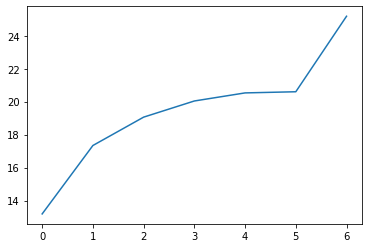

In [2070]:
plt.plot((pcp4f['rbins']-pcp4['rbins']))

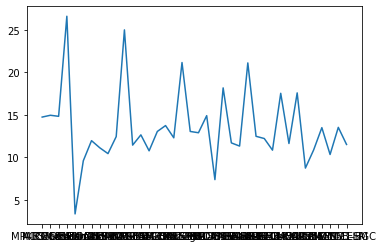

In [2071]:
plt.plot((cmip_read['2080']['tcw_mean']))

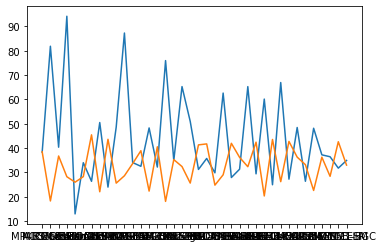

In [2072]:
plt.plot((cmip_read['2080']['tcw_mean'])/(cmip_read['2080']['tcw_hist'])*100)
plt.plot((cmip_read['2080']['tcw_hist']))

In [2073]:
np.mean(pcp4['rbins'])  # tcw mean from percentile mean

42.26142857142857

In [2074]:
np.mean(cp4.tcwv) # tcw mean from MCS mean

40.55026106069391

In [2075]:
percents

array([10.05, 30.  , 50.  , 67.5 , 80.  , 90.  , 97.45])

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Scaling per percentile [1.15814246 1.39144796 1.47838195 1.17198273 1.30019928 1.52544702
 1.30792304]
Percentage median 1.3079230448611032
Percentage abs  0.8580996819316653
Deltatcw [13.19 17.34 19.06 20.04 20.53 20.6  25.18] [0.48599853 0.46043548 0.46105467 0.45545455 0.44620735 0.42791857
 0.48855258]
Deltaprecip [15.64720218 18.58575523 19.38626732 15.67595339 16.50914583 17.67685345
 18.26667974] [0.56285553 0.640672   0.6816149  0.53378486 0.58015847 0.65276711
 0.63898918]


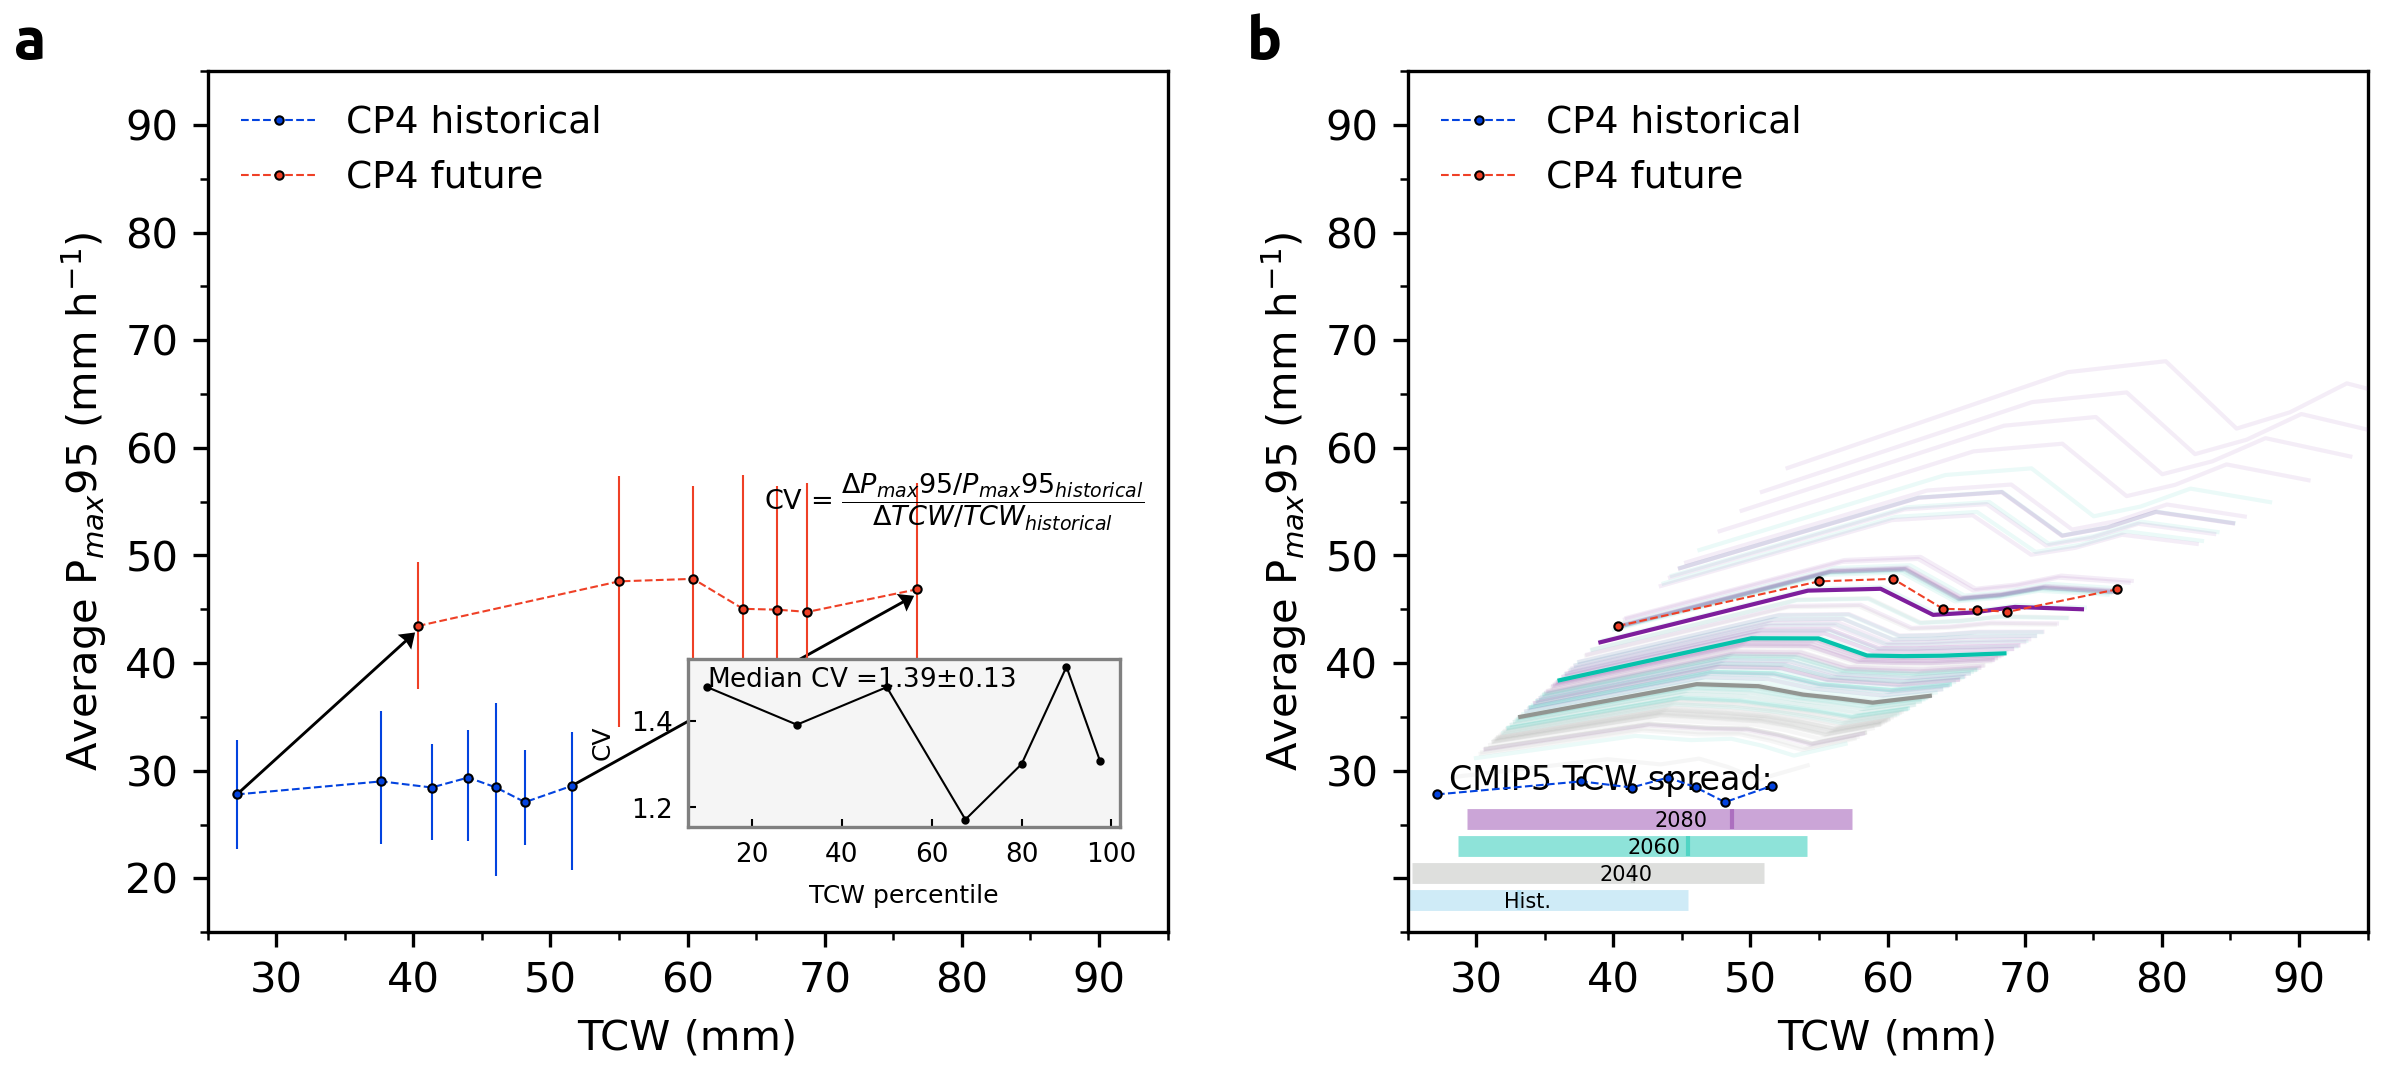

In [2076]:
f = plt.figure(figsize=(8,3.5), dpi=300)
widthnorm = 0.40
heightnorm = 0.82
bottomnorm=0.13

left, bottom, width, height = [0.58, bottomnorm, widthnorm, heightnorm]
ax = f.add_axes([left, bottom, width, height])
posis = [10.5,13,15.5]
alphas = [0.3,0.45,0.4]
ccolors = ['xkcd:grey', 'xkcd:turquoise', 'xkcd:purple']
dy = 10

#####
spread = ((cmip_read['2040'])['tcw_hist'])
mins = np.min(spread)
maxs = np.max(spread)
median = np.median(spread)
#ipdb.set_trace()
ax.errorbar(np.array(median), np.array(8+dy), xerr=np.array([[median-mins, maxs-median]]).T, color='skyblue', linewidth=5, alpha=0.4, linestyle='solid', capthick=0, marker='|', capsize=0, markersize=5)
idss=0
for ids, stry in enumerate(['2040', '2060', '2080']):
    idss += idss+1
    ##########
    spread = ((cmip_read[stry])['tcw_mean'])+((cmip_read[stry])['tcw_hist'])
    mins = np.min(spread)
    maxs = np.max(spread)
    median = np.median(spread)
    #ipdb.set_trace()
    ax.errorbar(np.array(median), np.array(posis[ids]+dy), xerr=np.array([[median-mins, maxs-median]]).T, color=ccolors[ids], linewidth=5, alpha=alphas[ids], linestyle='solid', capthick=0, marker='|', capsize=0, markersize=5)

ax.spines['top'].set_visible(True)
ax.spines['top'].set_linewidth(0.8)


ax.text(28,18.25+dy,'CMIP5 TCW spread:', fontsize=8)
ax.text(32,7.25+dy,'Hist.', fontsize=5)
ax.text(39,9.75+dy,'2040', fontsize=5)
ax.text(41,12.25+dy,'2060', fontsize=5)
ax.text(43,14.75+dy,'2080', fontsize=5)
####

# ax.plot(pcp4['rbins'],pcp4['pmean'], color='mediumblue',  label=r'CP4 historical', linestyle='',marker='o', markersize=3)  #marker='o', markersize=1, #cornflowerblue
# ax.plot(pcp4f['rbins'],pcp4f['pmean'], color='red', label=r'CP4 future', linestyle='',marker='o', markersize=3) #, marker='o', markersize=1


histline = np.array(pcp4['pmean']) #np.array((pcp4['rslope']*pcp4['rbins']+pcp4['rintercept']))
futline = np.array(pcp4f['pmean']) #np.array(pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'])

ax.plot(pcp4['rbins'],histline, color='xkcd:blue', linestyle='dashed', linewidth=0.5, markersize=2, label='CP4 historical', mfc='xkcd:blue',  marker='o', markeredgecolor='k', markeredgewidth=0.5, zorder=99)
ax.plot(pcp4f['rbins'], futline, color='xkcd:tomato', linestyle='dashed', linewidth=0.5, markersize=2, label='CP4 future', mfc='xkcd:tomato', marker='o', markeredgecolor='k', markeredgewidth=0.5, zorder=99)


pick = np.array([0,-1])
ax.set_xlim(25,95)
ax.set_ylim(15,95)
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_yticklabels(['','',30,40,50,60,70,80,90])
ax.legend(loc='upper left', frameon=False, fontsize=9)
coll = []
abss = []
collmm = []

for ids, percs in enumerate(percents):

    ppabs = (futline[ids]-histline[ids])/(pcp4f['rbins'][ids]-pcp4['rbins'][ids])

    aprcp = (futline[ids]-histline[ids])/histline[ids]
    btcw = (pcp4f['rbins'][ids]-pcp4['rbins'][ids])/pcp4['rbins'][ids]
    pperc = aprcp/btcw
    coll.append(pperc)

    abss.append(ppabs)
    
coll = np.array(coll)


        
print('Scaling per percentile', coll)
    
for yyinds, yy in enumerate(['2040', '2060', '2080']):
    cmip_rrel = []
    cmip_rel = (cmip_read[yy]['tcw_mean'])/(cmip_read[yy]['tcw_hist'])  #cp4_historical_domainMean #/np.mean(cp4.tcwv)# relative to average MCS tcw ; i.e. if this is the change that ocurrs relative to MCS baseline tcw / compares domain-wide aggregate to domain-wide aggregate
    for crbins in (cmip_read[yy]['tcw_mean']):
        cmip_rrel.append(crbins/np.array(pcp4['rbins']))
    
    cmip_rrel = np.array(cmip_rrel)
    #ipdb.set_trace()
        
    cmip_diff = (cmip_read[yy]['tcw_mean'])
 
    for cinds, cmip_di in enumerate(cmip_rel):
        cmipfut = np.array(pcp4['rbins'])+np.array(pcp4['rbins'])*cmip_di
        cmean = histline+histline*(cmip_di)*coll
        ax.plot(cmipfut, cmean, color=ccolors[yyinds], linewidth=1, alpha=0.08, markersize=1, zorder=5)

        
#     for cinds, cmip_di in enumerate(cmip_read[yy]['tcw_mean']):
#         cmipfut = np.array(pcp4['rbins'])+cmip_di
#         cmean = histline+np.array(coll)*(cmip_di) 
#         ax.plot(cmipfut, cmean, color=ccolors[yyinds], linewidth=1, alpha=0.08, markersize=1, zorder=5)

    cmean = histline+histline*(np.mean(cmip_rel))*coll #

    ax.plot(np.array(pcp4['rbins'])+np.array(pcp4['rbins'])*np.mean(cmip_rel), cmean, color=ccolors[yyinds], zorder=95, linewidth=1, alpha=1, markersize=2)
    
    #reconstructed CP4 RAINFALL
   # ax.plot(np.array(pcp4f['rbins']), histline+histline*((pcp4f['rbins']-pcp4['rbins'])/pcp4['rbins'])*coll, color='r', linewidth=2)
    
print('Percentage median', np.median(coll))
print('Percentage abs ', np.median(abss))

ax.set_xlabel(r'TCW (mm)')
ax.set_ylabel('Average P$_{max}$95 (mm h$^{-1}$)')


#####################################################################################################################
left, bottom, width, height = [0.08, bottomnorm, widthnorm, heightnorm]
ax = f.add_axes([left, bottom, width, height])
posis = [79,81,83]
alphas = [0.3,0.45,0.6]


ax.plot(pcp4['rbins'],pcp4['pmean'], color='xkcd:blue',  label=r'CP4 historical', linestyle='dashed',marker='o', markersize=2, linewidth=0.5, markeredgecolor='k', markeredgewidth=0.5)  #marker='o', markersize=1, #cornflowerblue
ax.plot(pcp4f['rbins'],pcp4f['pmean'], color='xkcd:tomato', label=r'CP4 future', linestyle='dashed', marker='o',markersize=2, linewidth=0.5, markeredgecolor='k', markeredgewidth=0.5) #, marker='o', markersize=1
ax.errorbar(pcp4['rbins'], pcp4['pmean'], yerr=[np.array(pcp4['pmean'])-np.array(pcp4['p10']),np.array(pcp4['p90'])-np.array(pcp4['pmean'])], color='xkcd:blue', linewidth=0.5, linestyle='')
ax.errorbar(pcp4f['rbins'], pcp4f['pmean'], yerr=[np.array(pcp4f['pmean'])-np.array(pcp4f['p10']),np.array(pcp4f['p90'])-np.array(pcp4f['pmean'])], color='xkcd:tomato', linewidth=0.5, linestyle='')
pick = np.array([0,-1])

yh = (histline)[pick]
xh = pcp4['rbins'][pick]
yf = (futline)[pick]
xf = pcp4f['rbins'][pick]
ax.quiver(xh, yh,(xf)-xh-0.2,yf-yh-0.6, angles='xy', scale_units='xy', scale=1, color='k', width=0.003, zorder=0, headwidth=7, linestyle='dotted')

# ax.plot(pcp4['rbins'],histline, color='k', linestyle='dashed', linewidth=0.5,marker='o', markersize=1)
# ax.plot(pcp4f['rbins'], futline, color='k', linestyle='dashed', linewidth=0.5,marker='o', markersize=1)


ax.set_xlim(25,95)
ax.set_ylim(15,95)
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))

ax.legend(loc='upper left', frameon=False, fontsize=9)
ax.text(0.58, 0.49,r'CV = $\dfrac{\Delta P_{max}95 / P_{max}95_{historical}}{\Delta TCW / TCW_{historical}}$', transform=ax.transAxes, fontsize=6.5) # 0.83

print('Deltatcw', pcp4f['rbins']-pcp4['rbins'], ( pcp4f['rbins']-pcp4['rbins'])/pcp4['rbins'] )

print('Deltaprecip', np.array(pcp4f['pmean'])-np.array(pcp4['pmean']), (np.array(pcp4f['pmean'])-np.array(pcp4['pmean'])) / np.array(pcp4['pmean']))



#ax.text(0.58, 0.41,r'$\dfrac{\delta P_{max} 95}{\delta TCW}$: '+str(np.round(np.mean(abss),2))+'$\pm$'+str(np.round(np.std(abss),2))+' mm h$^{-1}$', transform=ax.transAxes, fontsize=6.5)

coll[0] = coll[2]
fdic = {'rel': np.array(coll), 'abs' : abss, 'tcw_hist' : pcp4['rbins'], 'prcp_hist' :  pcp4['pmean'], 'tcw_fut' : pcp4f['rbins'], 'prcp_fut' :  pcp4f['pmean']} #, 'futslope': pcp4f['rslope'], 'histslope' : pcp4['rslope'],  'futinter' : pcp4f['rintercept'], 'histinter' : pcp4['rintercept'], 
import pickle
pickle.dump(fdic, open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors_'+region+'_955.p', "wb"))

ax.set_xlabel(r'TCW (mm)')
ax.set_ylabel('Average P$_{max}$95 (mm h$^{-1}$)')

left, bottom, width, height = [0.28, 0.23, 0.18, 0.16] #[0.275, 0.2, 0.20, 0.27]
ax3 = f.add_axes([left, bottom, width, height])
#ax3.plot(pcp4['bins'], coll, color='k', linestyle='solid', linewidth=0.5,marker='o', markersize=1)
ax3.plot(pcp4['bins'], coll, color='k', linestyle='solid', linewidth=0.5,marker='o', markersize=1)
ax3.text(0.52, 0.285,r'Median CV ='+str(np.round(np.median(coll),2))+'$\pm$'+str(np.round(np.max(coll)-np.median(coll),2)), transform=ax.transAxes, fontsize=6.3) # 0.83
ax3.set_xlabel('TCW percentile', fontsize=6)
ax3.set_ylabel('CV',fontsize=6)

# ax3.set_xticklabels('')
# ax3.set_yticklabels('')
# ax3.set_xlim(32,62)
# ax3.set_ylim(30,85)

for axis in ['top','bottom','left','right']:
  
  ax3.spines[axis].set_color('grey')
# ax3.spines['right'].set_visible(False)
# ax3.spines['top'].set_visible(False)
ax3.tick_params(direction='in', length=2, width=0.5, colors='k', labelsize=6.3)
ax3.set_facecolor('whitesmoke')

text = ['a', 'b']
plt.tight_layout()
plt.annotate(text[0], xy=(0.006, 0.93), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=14)
plt.annotate(text[1], xy=(0.52, 0.93), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=14)


plt.savefig(cnst.network_data + 'figs/ENDGAME/scatter_hourly_OBS_CP4_TCWV_CMIPscaling_relative_CMIP_9-19N_20masked_CV_0.1mm_'+region+'.jpg')

Scaling per percentile [1.15814246 1.39144796 1.47838195 1.17198273 1.30019928 1.52544702
 1.30792304]
Percentage median 1.3079230448611032
Percentage abs  0.8580996819316653
Deltatcw [13.19 17.34 19.06 20.04 20.53 20.6  25.18] [0.48599853 0.46043548 0.46105467 0.45545455 0.44620735 0.42791857
 0.48855258]
Deltaprecip [15.64720218 18.58575523 19.38626732 15.67595339 16.50914583 17.67685345
 18.26667974] [0.56285553 0.640672   0.6816149  0.53378486 0.58015847 0.65276711
 0.63898918]


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Text(0, 4, 'b')

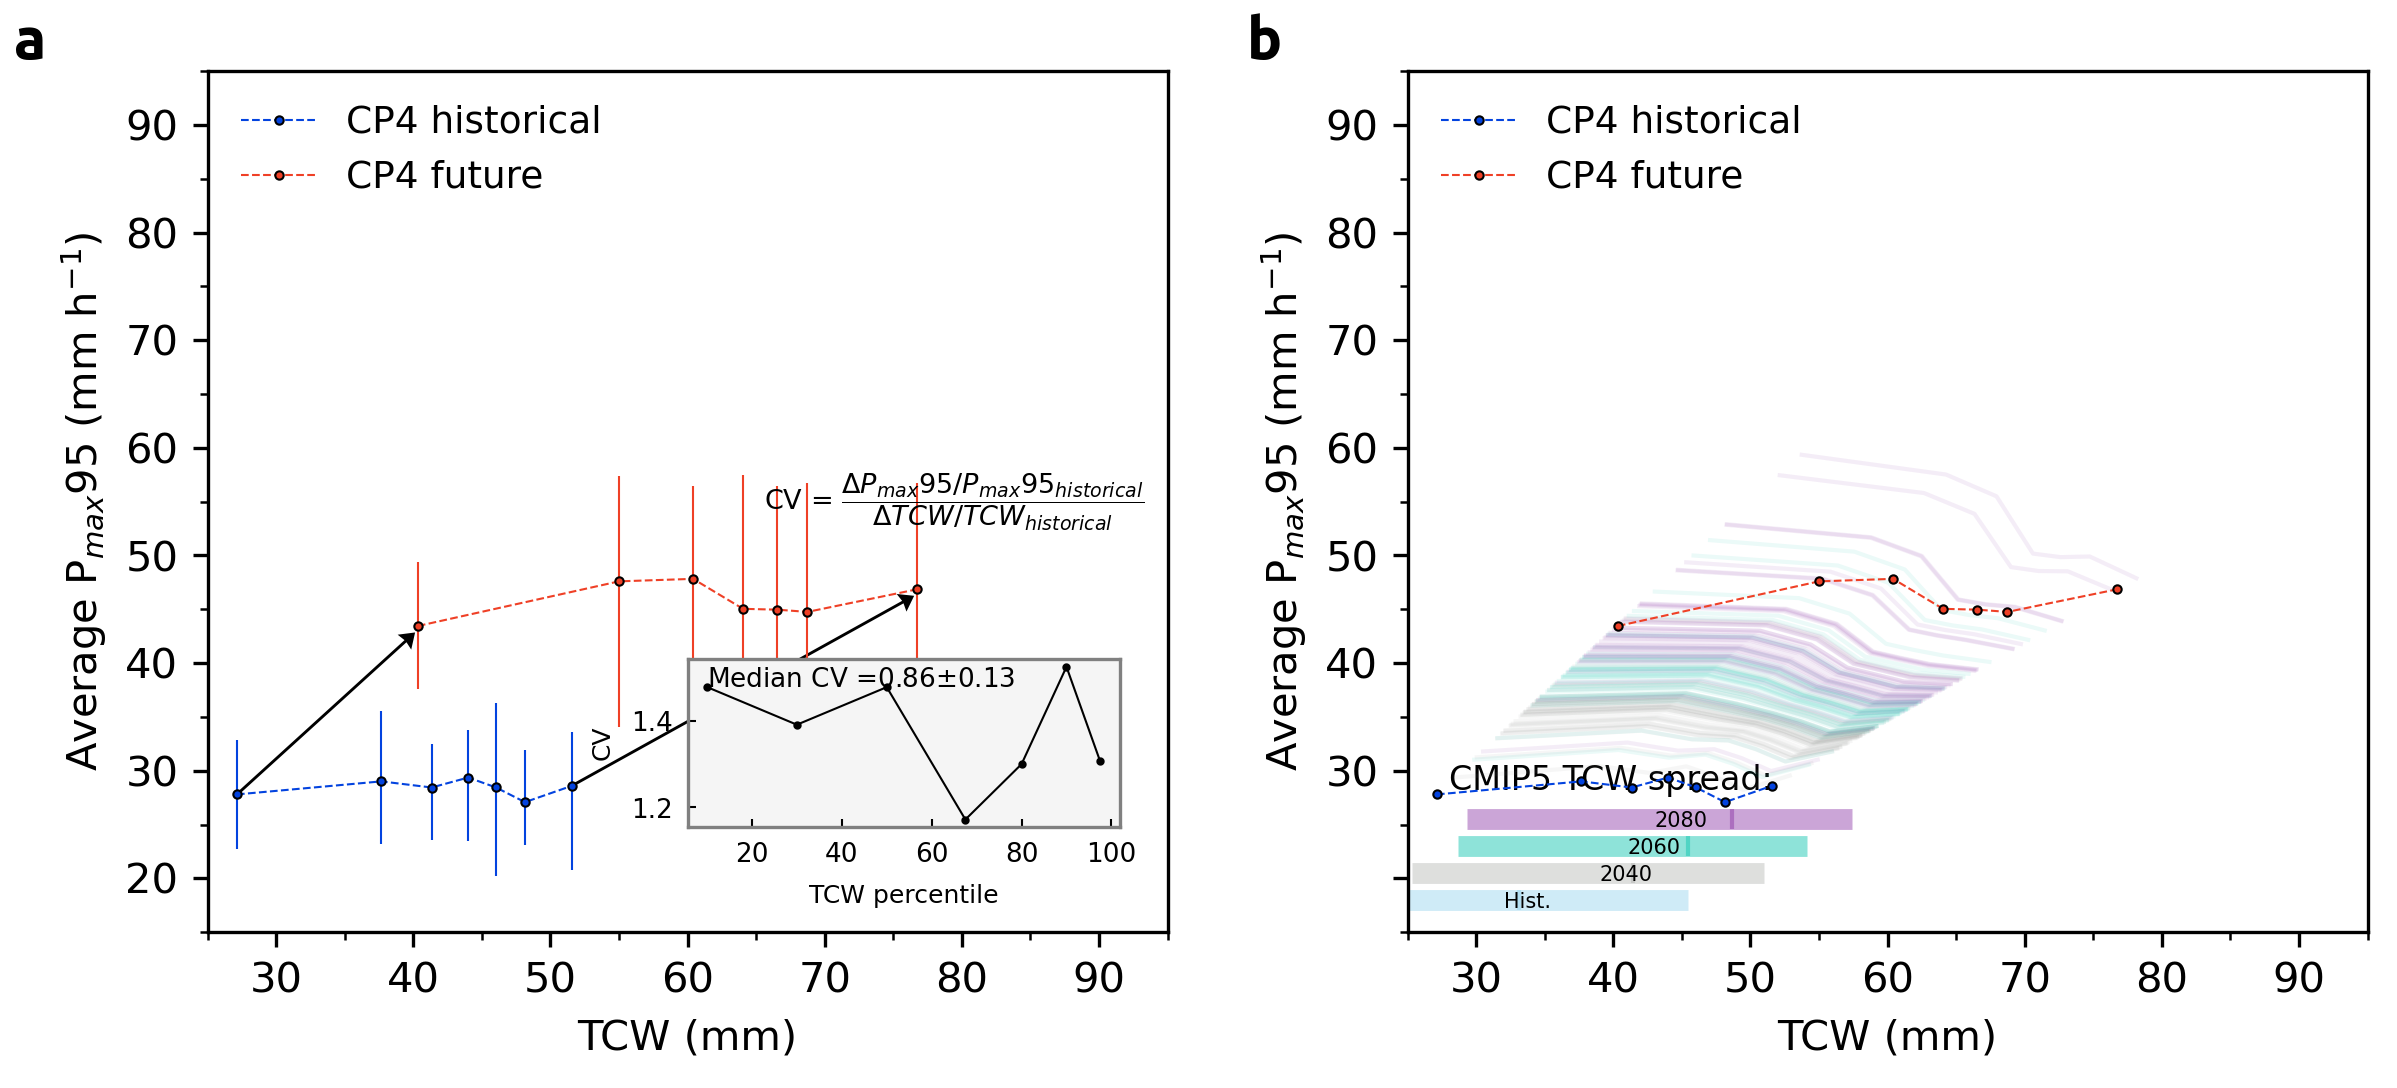

In [2077]:
f = plt.figure(figsize=(8,3.5), dpi=300)
widthnorm = 0.40
heightnorm = 0.82
bottomnorm=0.13

left, bottom, width, height = [0.58, bottomnorm, widthnorm, heightnorm]
ax = f.add_axes([left, bottom, width, height])
posis = [10.5,13,15.5]
alphas = [0.3,0.45,0.4]
ccolors = ['xkcd:grey', 'xkcd:turquoise', 'xkcd:purple']
dy = 10

#####
spread = ((cmip_read['2040'])['tcw_hist'])
mins = np.min(spread)
maxs = np.max(spread)
median = np.median(spread)
#ipdb.set_trace()
ax.errorbar(np.array(median), np.array(8+dy), xerr=np.array([[median-mins, maxs-median]]).T, color='skyblue', linewidth=5, alpha=0.4, linestyle='solid', capthick=0, marker='|', capsize=0, markersize=5)
idss=0
for ids, stry in enumerate(['2040', '2060', '2080']):
    idss += idss+1
    ##########
    spread = ((cmip_read[stry])['tcw_mean'])+((cmip_read[stry])['tcw_hist'])
    mins = np.min(spread)
    maxs = np.max(spread)
    median = np.median(spread)
    #ipdb.set_trace()
    ax.errorbar(np.array(median), np.array(posis[ids]+dy), xerr=np.array([[median-mins, maxs-median]]).T, color=ccolors[ids], linewidth=5, alpha=alphas[ids], linestyle='solid', capthick=0, marker='|', capsize=0, markersize=5)

ax.spines['top'].set_visible(True)
ax.spines['top'].set_linewidth(0.8)


ax.text(28,18.25+dy,'CMIP5 TCW spread:', fontsize=8)
ax.text(32,7.25+dy,'Hist.', fontsize=5)
ax.text(39,9.75+dy,'2040', fontsize=5)
ax.text(41,12.25+dy,'2060', fontsize=5)
ax.text(43,14.75+dy,'2080', fontsize=5)
####

# ax.plot(pcp4['rbins'],pcp4['pmean'], color='mediumblue',  label=r'CP4 historical', linestyle='',marker='o', markersize=3)  #marker='o', markersize=1, #cornflowerblue
# ax.plot(pcp4f['rbins'],pcp4f['pmean'], color='red', label=r'CP4 future', linestyle='',marker='o', markersize=3) #, marker='o', markersize=1


histline = np.array(pcp4['pmean']) #np.array((pcp4['rslope']*pcp4['rbins']+pcp4['rintercept']))
futline = np.array(pcp4f['pmean']) #np.array(pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'])

ax.plot(pcp4['rbins'],histline, color='xkcd:blue', linestyle='dashed', linewidth=0.5, markersize=2, label='CP4 historical', mfc='xkcd:blue',  marker='o', markeredgecolor='k', markeredgewidth=0.5, zorder=99)
ax.plot(pcp4f['rbins'], futline, color='xkcd:tomato', linestyle='dashed', linewidth=0.5, markersize=2, label='CP4 future', mfc='xkcd:tomato', marker='o', markeredgecolor='k', markeredgewidth=0.5, zorder=99)


pick = np.array([0,-1])
ax.set_xlim(25,95)
ax.set_ylim(15,95)
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_yticklabels(['','',30,40,50,60,70,80,90])
ax.legend(loc='upper left', frameon=False, fontsize=9)
coll = []
abss = []
collmm = []

for ids, percs in enumerate(percents):

    ppabs = (futline[ids]-histline[ids])/(pcp4f['rbins'][ids]-pcp4['rbins'][ids])

    aprcp = (futline[ids]-histline[ids])/histline[ids]
    btcw = (pcp4f['rbins'][ids]-pcp4['rbins'][ids])/pcp4['rbins'][ids]
    pperc = aprcp/btcw
    coll.append(pperc)

    abss.append(ppabs)
    
coll = np.array(coll)


        
print('Scaling per percentile', coll)
    
for yyinds, yy in enumerate(['2040', '2060', '2080']):
    cmip_rrel = []
    cmip_rel = (cmip_read[yy]['tcw_mean'])#/(cmip_read[yy]['tcw_hist'])  #cp4_historical_domainMean #/np.mean(cp4.tcwv)# relative to average MCS tcw ; i.e. if this is the change that ocurrs relative to MCS baseline tcw / compares domain-wide aggregate to domain-wide aggregate
    for crbins in (cmip_read[yy]['tcw_mean']):
        cmip_rrel.append(crbins/np.array(pcp4['rbins']))
    
    cmip_rrel = np.array(cmip_rrel)
    #ipdb.set_trace()
        
    cmip_diff = (cmip_read[yy]['tcw_mean'])
 
    for cinds, cmip_di in enumerate(cmip_rel):
        cmipfut = np.array(pcp4['rbins'])+cmip_di
        cmean = histline+(cmip_di)*np.array(abss)#*coll
        ax.plot(cmipfut, cmean, color=ccolors[yyinds], linewidth=1, alpha=0.08, markersize=1, zorder=5)

        
#     for cinds, cmip_di in enumerate(cmip_read[yy]['tcw_mean']):
#         cmipfut = np.array(pcp4['rbins'])+cmip_di
#         cmean = histline+np.array(coll)*(cmip_di) 
#         ax.plot(cmipfut, cmean, color=ccolors[yyinds], linewidth=1, alpha=0.08, markersize=1, zorder=5)

    cmean = histline+histline*(np.mean(cmip_rel))*coll #

    ax.plot(np.array(pcp4['rbins'])+np.array(pcp4['rbins'])*np.mean(cmip_rel), cmean, color=ccolors[yyinds], zorder=95, linewidth=1, alpha=1, markersize=2)
    
    #reconstructed CP4 RAINFALL
   # ax.plot(np.array(pcp4f['rbins']), histline+histline*((pcp4f['rbins']-pcp4['rbins'])/pcp4['rbins'])*coll, color='r', linewidth=2)
    
print('Percentage median', np.median(coll))
print('Percentage abs ', np.median(abss))

ax.set_xlabel(r'TCW (mm)')
ax.set_ylabel('Average P$_{max}$95 (mm h$^{-1}$)')


#####################################################################################################################
left, bottom, width, height = [0.08, bottomnorm, widthnorm, heightnorm]
ax = f.add_axes([left, bottom, width, height])
posis = [79,81,83]
alphas = [0.3,0.45,0.6]


ax.plot(pcp4['rbins'],pcp4['pmean'], color='xkcd:blue',  label=r'CP4 historical', linestyle='dashed',marker='o', markersize=2, linewidth=0.5, markeredgecolor='k', markeredgewidth=0.5)  #marker='o', markersize=1, #cornflowerblue
ax.plot(pcp4f['rbins'],pcp4f['pmean'], color='xkcd:tomato', label=r'CP4 future', linestyle='dashed', marker='o',markersize=2, linewidth=0.5, markeredgecolor='k', markeredgewidth=0.5) #, marker='o', markersize=1
ax.errorbar(pcp4['rbins'], pcp4['pmean'], yerr=[np.array(pcp4['pmean'])-np.array(pcp4['p10']),np.array(pcp4['p90'])-np.array(pcp4['pmean'])], color='xkcd:blue', linewidth=0.5, linestyle='')
ax.errorbar(pcp4f['rbins'], pcp4f['pmean'], yerr=[np.array(pcp4f['pmean'])-np.array(pcp4f['p10']),np.array(pcp4f['p90'])-np.array(pcp4f['pmean'])], color='xkcd:tomato', linewidth=0.5, linestyle='')
pick = np.array([0,-1])

yh = (histline)[pick]
xh = pcp4['rbins'][pick]
yf = (futline)[pick]
xf = pcp4f['rbins'][pick]
ax.quiver(xh, yh,(xf)-xh-0.2,yf-yh-0.6, angles='xy', scale_units='xy', scale=1, color='k', width=0.003, zorder=0, headwidth=7, linestyle='dotted')

# ax.plot(pcp4['rbins'],histline, color='k', linestyle='dashed', linewidth=0.5,marker='o', markersize=1)
# ax.plot(pcp4f['rbins'], futline, color='k', linestyle='dashed', linewidth=0.5,marker='o', markersize=1)


ax.set_xlim(25,95)
ax.set_ylim(15,95)
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))

ax.legend(loc='upper left', frameon=False, fontsize=9)
ax.text(0.58, 0.49,r'CV = $\dfrac{\Delta P_{max}95 / P_{max}95_{historical}}{\Delta TCW / TCW_{historical}}$', transform=ax.transAxes, fontsize=6.5) # 0.83

print('Deltatcw', pcp4f['rbins']-pcp4['rbins'], ( pcp4f['rbins']-pcp4['rbins'])/pcp4['rbins'] )

print('Deltaprecip', np.array(pcp4f['pmean'])-np.array(pcp4['pmean']), (np.array(pcp4f['pmean'])-np.array(pcp4['pmean'])) / np.array(pcp4['pmean']))



#ax.text(0.58, 0.41,r'$\dfrac{\delta P_{max} 95}{\delta TCW}$: '+str(np.round(np.mean(abss),2))+'$\pm$'+str(np.round(np.std(abss),2))+' mm h$^{-1}$', transform=ax.transAxes, fontsize=6.5)

coll[0] = coll[2]
fdic = {'rel': np.array(coll), 'abs' : abss, 'tcw_hist' : pcp4['rbins'], 'prcp_hist' :  pcp4['pmean'], 'tcw_fut' : pcp4f['rbins'], 'prcp_fut' :  pcp4f['pmean']} #, 'futslope': pcp4f['rslope'], 'histslope' : pcp4['rslope'],  'futinter' : pcp4f['rintercept'], 'histinter' : pcp4['rintercept'], 
import pickle
#pickle.dump(fdic, open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors_'+region+'_95.p', "wb"))

ax.set_xlabel(r'TCW (mm)')
ax.set_ylabel('Average P$_{max}$95 (mm h$^{-1}$)')

left, bottom, width, height = [0.28, 0.23, 0.18, 0.16] #[0.275, 0.2, 0.20, 0.27]
ax3 = f.add_axes([left, bottom, width, height])
#ax3.plot(pcp4['bins'], coll, color='k', linestyle='solid', linewidth=0.5,marker='o', markersize=1)
ax3.plot(pcp4['bins'], coll, color='k', linestyle='solid', linewidth=0.5,marker='o', markersize=1)
ax3.text(0.52, 0.285,r'Median CV ='+str(np.round(np.median(abss),2))+'$\pm$'+str(np.round(np.max(coll)-np.median(coll),2)), transform=ax.transAxes, fontsize=6.3) # 0.83
ax3.set_xlabel('TCW percentile', fontsize=6)
ax3.set_ylabel('CV',fontsize=6)

# ax3.set_xticklabels('')
# ax3.set_yticklabels('')
# ax3.set_xlim(32,62)
# ax3.set_ylim(30,85)

for axis in ['top','bottom','left','right']:
  
  ax3.spines[axis].set_color('grey')
# ax3.spines['right'].set_visible(False)
# ax3.spines['top'].set_visible(False)
ax3.tick_params(direction='in', length=2, width=0.5, colors='k', labelsize=6.3)
ax3.set_facecolor('whitesmoke')

text = ['a', 'b']
plt.tight_layout()
plt.annotate(text[0], xy=(0.006, 0.93), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=14)
plt.annotate(text[1], xy=(0.52, 0.93), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=14)


#plt.savefig(cnst.network_data + 'figs/ENDGAME/scatter_hourly_OBS_CP4_TCWV_CMIPscaling_relative_CMIP_9-19N_20masked_CV_0.1mm_'+region+'.jpg')